In [1]:
from dann0 import DANN
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.backend import tensorflow_backend as K
from keras.optimizers import Adam, SGD
import pandas as pd
from tqdm import tqdm
from PIL import Image
from keras.utils import to_categorical

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
K.set_session(session)

Using TensorFlow backend.
W0312 11:47:36.789223 4399717824 module_wrapper.py:139] From /Users/jinsakuma/Documents/Python_dev/DANN/dann0.py:20: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0312 11:47:36.789834 4399717824 module_wrapper.py:139] From /Users/jinsakuma/Documents/Python_dev/DANN/dann0.py:20: The name tf.GPUOptions is deprecated. Please use tf.compat.v1.GPUOptions instead.

W0312 11:47:36.790258 4399717824 module_wrapper.py:139] From /Users/jinsakuma/Documents/Python_dev/DANN/dann0.py:21: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from sklearn.manifold import TSNE
%matplotlib inline

In [3]:
def load_data(dir_path, size=32):
    imgs = []
    label = []
    dir_list = os.listdir(dir_path)
    for d in tqdm(dir_list):
        if '.' in d:
            continue
        label_path = os.path.join(dir_path, d)
        img_list = os.listdir(label_path)
        for img_name in img_list:
            if not ('.jpg' in img_name or '.png' in img_name):
                continue
            path = os.path.join(label_path, img_name)
            img = Image.open(path).convert("RGB")
            img = img.resize((32, 32), Image.BICUBIC)
            img = np.asarray(img)/127.5 - 1.
            imgs.append(img)
            label.append(int(d))
    X = np.asarray(imgs)
    y = np.asarray(to_categorical(label))
    label = np.asarray(label)

    return X, y, label

In [4]:
test_sX, test_sY, test_slabel = load_data('./data/MNIST/test/') 
test_tX, test_tY, test_tlabel = load_data('./data/MNIST-M/test/') 

100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


In [5]:
from configs.cfg import Config
config = Config()
dann = DANN(n_classes=10, output_name="output/", config=config)

W0312 11:47:42.105720 4399717824 module_wrapper.py:139] From /Users/jinsakuma/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0312 11:47:42.106490 4399717824 module_wrapper.py:139] From /Users/jinsakuma/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0312 11:47:42.110433 4399717824 module_wrapper.py:139] From /Users/jinsakuma/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0312 11:47:42.122880 4399717824 module_wrapper.py:139] From /Users/jinsakuma/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0312 11:47:42.190670 439971782

In [6]:
index1 = np.arange(len(test_sX))
index2 = np.arange(len(test_tX))
np.random.seed(0)
np.random.shuffle(index1)
np.random.shuffle(index2)

N = 1000

sample_sX = test_sX[index1[:N]]
sample_sY = test_slabel[index1[:N]]
sample_tX = test_tX[index2[:N]]
sample_tY = test_tlabel[index2[:N]]

In [20]:
optimizer = SGD(lr=0.001, momentum=0.9)
model_source_only = dann.classifier
model_source_only.load_weights('output/source_only_49.88.hdf5') 
model_source_only.compile(loss="categorical_crossentropy",                     
                    metrics=["accuracy"],
                    optimizer=optimizer)

In [21]:
res_s = model_source_only.evaluate(test_sX, test_sY)
res_t = model_source_only.evaluate(test_tX, test_tY)

print('<Source Only>')
print('Source: {:.2f}%'.format(res_s[1]*100))
print('Target: {:.2f}%'.format(res_t[1]*100))

9001/9001 [==============================] - 1s 155us/step
<Source Only>
Source: 96.34%
Target: 49.94%


In [22]:
model_source_only.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
extracter (Network)          (None, 3072)              40880     
_________________________________________________________________
classifier (Network)         (None, 10)                318410    
Total params: 359,290
Trainable params: 359,290
Non-trainable params: 0
_________________________________________________________________


In [23]:
from keras.models import Model

feature_extracter_1 = Model(inputs=model_source_only.get_layer('extracter').get_input_at(0), outputs=model_source_only.get_layer('extracter').get_output_at(0))

In [24]:
output1_s = feature_extracter_1.predict(sample_sX)
output1_t = feature_extracter_1.predict(sample_tX)

In [25]:
decomp = TSNE(n_components=2)
X_decomp1 = decomp.fit_transform(np.concatenate([output1_s, output1_t]))

W0312 12:03:50.394568 4399717824 legend.py:1282] No handles with labels found to put in legend.


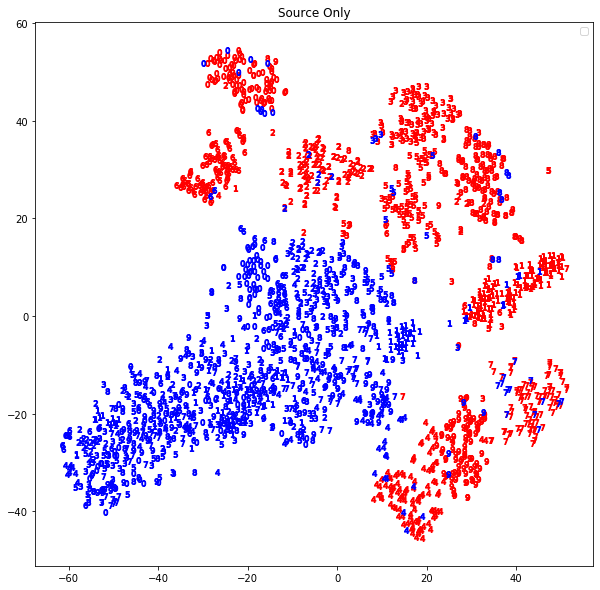

In [39]:
plt.figure(figsize=(10, 10))

for i, l in enumerate(np.concatenate([sample_sY, sample_tY])):
    marker = "$" + str(l) + "$"
    if i<1000:
        plt.scatter(X_decomp1[i, 0], X_decomp1[i, 1], marker=marker, color='r')
    else:
        plt.scatter(X_decomp1[i, 0], X_decomp1[i, 1], marker=marker, color='b')
plt.legend()
plt.title("Source Only")
plt.savefig('source_only.jpg')
plt.show()

In [27]:
optimizer = SGD(lr=0.001, momentum=0.9)
model_dann = dann.classifier
#model_dann.load_weights('output/dann_acc-0.68_loss-1.06.hdf5') 
# model_dann.load_weights('output/dann_acc-0.72_loss-1.01.hdf5') 
model_dann.load_weights('output/dann_acc-0.76_loss-0.92.hdf5') 
model_dann.compile(loss="categorical_crossentropy",                     
                    metrics=["accuracy"],
                    optimizer=optimizer)

In [28]:
res_s = model_dann.evaluate(test_sX, test_sY)
res_t = model_dann.evaluate(test_tX, test_tY)

print('<DANN>')
print('Source: {:.2f}%'.format(res_s[1]*100))
print('Target: {:.2f}%'.format(res_t[1]*100))

9001/9001 [==============================] - 1s 155us/step
<DANN>
Source: 98.47%
Target: 70.25%


In [29]:
# feature_extracter_2 = Model(inputs=model_dann.get_layer('extracter').get_input_at(0), outputs=model_dann.get_layer('extracter').get_output_at(0))
feature_extracter_2 = Model(inputs=model_dann.get_layer('extracter').get_input_at(0), outputs=model_dann.get_layer('extracter').get_output_at(0))

In [30]:
output2_s = feature_extracter_2.predict(sample_sX)
output2_t = feature_extracter_2.predict(sample_tX)

In [31]:
X_decomp2 = decomp.fit_transform(np.concatenate([output2_s, output2_t]))

W0312 12:03:42.026499 4399717824 legend.py:1282] No handles with labels found to put in legend.


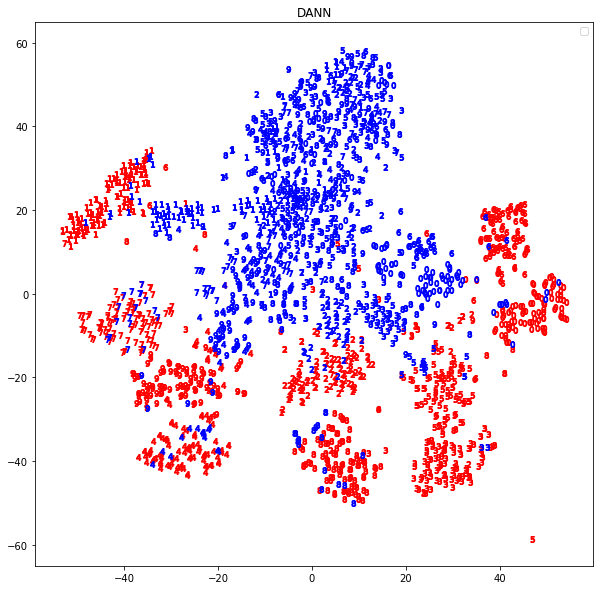

In [38]:
plt.figure(figsize=(10, 10))

for i, l in enumerate(np.concatenate([sample_sY, sample_tY])):
    marker = "$" + str(l) + "$"
    if i<1000:
        plt.scatter(X_decomp2[i, 0], X_decomp2[i, 1], marker=marker, color='r')
    else:
        plt.scatter(X_decomp2[i, 0], X_decomp2[i, 1], marker=marker, color='b')
        
plt.legend()
plt.title("DANN")
plt.savefig('dann.jpg')
plt.show()

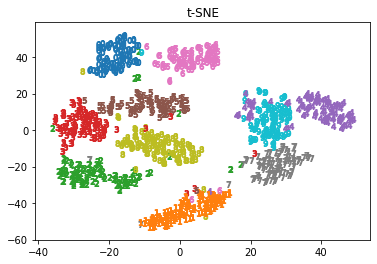

In [20]:
cmap = get_cmap("tab10")
for i, l in enumerate(sample_sY):
    marker = "$" + str(l) + "$"
    plt.scatter(X_decomp2_s[i, 0], X_decomp2_s[i, 1], marker=marker, color=cmap(l))
plt.title("t-SNE")
plt.show()

In [13]:
index1 = np.arange(len(test_sX))
index2 = np.arange(len(test_tX))
np.random.seed(0)
np.random.shuffle(index1)
np.random.shuffle(index2)

N = 500

sample_sX = test_sX[index1[:N]]
sample_sY = test_slabel[index1[:N]]
sample_tX = test_tX[index2[:N]]
sample_tY = test_tlabel[index2[:N]]

In [10]:
from keras.models import Model

feature_extracter_1 = Model(inputs=model_source_only.get_layer('extracter').get_input_at(0), outputs=model_source_only.get_layer('extracter').get_output_at(0))
feature_extracter_2 = Model(inputs=model_dann.get_layer('extracter').get_input_at(0), outputs=model_dann.get_layer('extracter').get_output_at(0))

NameError: name 'model_source_only' is not defined

In [14]:
output1_s = feature_extracter_1.predict(sample_sX)
output1_t = feature_extracter_1.predict(sample_tX)
output2_s = feature_extracter_2.predict(sample_sX)
output2_t = feature_extracter_2.predict(sample_tX)

In [15]:
decomp = TSNE(n_components=2)
X_decomp1_s = decomp.fit_transform(output1_s)
X_decomp1_t = decomp.fit_transform(output1_t)
X_decomp2_s = decomp.fit_transform(output2_s)
X_decomp2_t = decomp.fit_transform(output2_t)

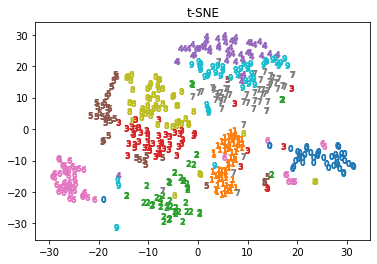

In [16]:
cmap = get_cmap("tab10")
for i, l in enumerate(sample_sY):
    marker = "$" + str(l) + "$"
    plt.scatter(X_decomp1_s[i, 0], X_decomp1_s[i, 1], marker=marker, color=cmap(l))
plt.title("t-SNE")
plt.show()

In [1]:
plt.figure(figsize=(10, 10))

for i, (ls, lt) in enumerate(zip(sample_sY, sample_tY)):
    marker_s = "$" + str(ls) + "$"
    marker_t = "$" + str(lt) + "$"
    plt.scatter(X_decomp1_s[i, 0], X_decomp1_s[i, 1], marker=marker_s, color='r')
    plt.scatter(X_decomp1_t[i, 0], X_decomp1_t[i, 1], marker=marker_t, color='b')
plt.title("t-SNE")
plt.show()

NameError: name 'plt' is not defined

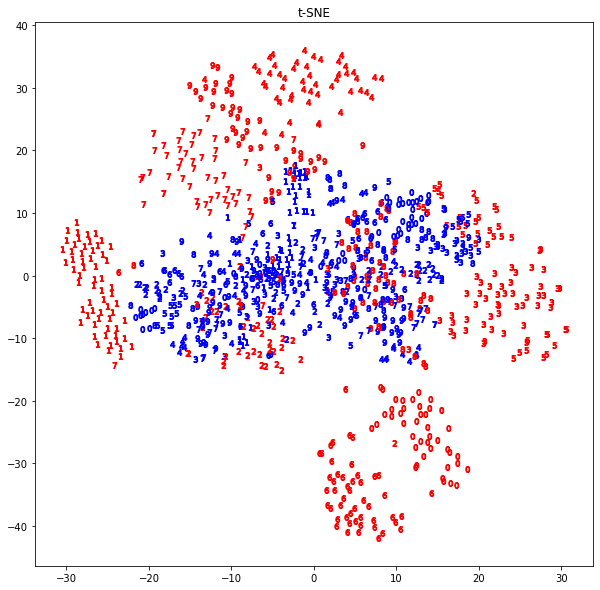

In [54]:
plt.figure(figsize=(10, 10))

for i, (ls, lt) in enumerate(zip(sample_sY, sample_tY)):
    marker_s = "$" + str(ls) + "$"
    marker_t = "$" + str(lt) + "$"
    plt.scatter(X_decomp2_s[i, 0], X_decomp2_s[i, 1], marker=marker_s, color='r')
    plt.scatter(X_decomp2_t[i, 0], X_decomp2_t[i, 1], marker=marker_t, color='b')
plt.title("t-SNE")
plt.show()

In [10]:
# from keras.models import Model

# feature_extracter_1 = Model(inputs=model_source_only.get_layer('Gen').get_input_at(0), outputs=model_source_only.get_layer('Gen').get_output_at(0))
# feature_extracter_2 = Model(inputs=model_dann.get_layer('Gen').get_input_at(0), outputs=model_dann.get_layer('Gen').get_output_at(0))

In [ ]:
for i, (ls, lt) in enumerate(zip(sample_sY, sample_tY)):
    marker_s = "$" + str(ls) + "$"
    marker_t = "$" + str(lt) + "$"
    plt.scatter(X_decomp1_s[i, 0], X_decomp1_s[i, 1], marker=marker_s, color='r')
    plt.scatter(X_decomp1_t[i, 0], X_decomp1_t[i, 1], marker=marker_t, color='b')
plt.title("t-SNE")
plt.show()

In [44]:
a = feature_extracter.predict(test_tX)
a.shape

(9001, 3072)

In [36]:
model_source_only.get_layer('Gen').summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 48)        38448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         


AttributeError: 'Network' object has no attribute '_check_trainable_weights_consistency'

In [ ]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
source_only_tsne = tsne.fit_transform(source_only_emb)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
dann_tsne = tsne.fit_transform(dann_emb)
        
plot_embedding(source_only_tsne, combined_test_labels.argmax(1), combined_test_domain.argmax(1), 'Source only')
plot_embedding(dann_tsne, combined_test_labels.argmax(1), combined_test_domain.argmax(1), 'Domain Adaptation')